In [127]:
import torch
from torch import nn,optim
import torchvision
from torchvision import transforms,datasets
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import time
import torchvision.models as models
import torch.nn.functional as F

### Load Data

In [128]:
image_transforms=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [129]:
dataset=datasets.ImageFolder(root='./dataset',transform=image_transforms)

In [130]:
len(dataset)

2300

In [131]:
dataset.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [132]:
num_classes=len(dataset.classes)

In [133]:
num_classes

6

In [134]:
sample, target = dataset[2]
class_name = dataset.classes[target]
print(class_name)

F_Breakage


In [135]:
target

0

In [136]:
sample.shape

torch.Size([3, 224, 224])

In [137]:
sample

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

In [138]:
dataset

Dataset ImageFolder
    Number of datapoints: 2300
    Root location: ./dataset
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [139]:
train_size=int(0.75*len(dataset))
train_size

1725

In [140]:
val_size=len(dataset)-train_size
val_size

575

In [141]:
from torch.utils.data import random_split
train_dataset,val_dataset=random_split(dataset,[train_size,val_size])

In [142]:
train_dataloader=DataLoader(train_dataset,batch_size=32,shuffle=True)
val_dataloader=DataLoader(val_dataset,batch_size=32,shuffle=False)


In [143]:
for image,labels in train_dataloader:
    print(image.shape)
    print(labels)
    break

torch.Size([32, 3, 224, 224])
tensor([3, 0, 4, 1, 1, 2, 5, 2, 4, 1, 0, 3, 3, 0, 2, 2, 2, 3, 1, 0, 5, 3, 2, 1,
        0, 0, 1, 4, 4, 2, 2, 4])


In [144]:
image[0].shape

torch.Size([3, 224, 224])

In [145]:
image[0].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.465708].


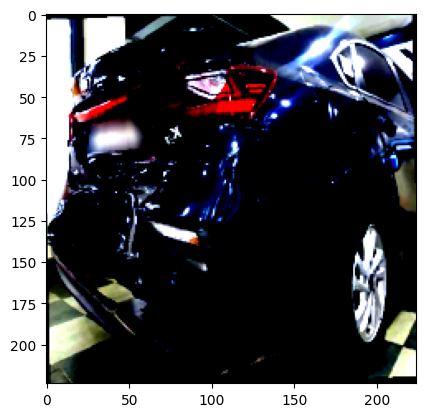

In [146]:
plt.imshow(image[0].permute(1,2,0))

In [155]:
class Detection(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,padding=1,stride=1),#input(3,224,224),output(16,224,224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),#output(16,112,112)
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1,stride=1),#input(16,112,112),output(32,112,112)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),#output(32,56,56),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1,stride=1),#input(32,56,56),output(64,56,56)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),#output(64,28,28),
            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.ReLU(),
            nn.Linear(512,num_classes)
        )
    def forward(self,x):
        return self.network(x)

In [156]:
model=Detection(num_classes=num_classes)
optimizer=optim.Adam(model.parameters(),lr=0.001)
Criterion=nn.CrossEntropyLoss()

In [162]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_dataloader):
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_dataloader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in val_dataloader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.numpy())
                all_predictions.extend(predicted.numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions
        

In [163]:
all_labels,all_predictions=train_model(model,Criterion,optimizer,epochs=5)

Batch: 10, Epoch: 1, Loss: 0.86
Batch: 20, Epoch: 1, Loss: 1.16
Batch: 30, Epoch: 1, Loss: 1.16
Batch: 40, Epoch: 1, Loss: 0.95
Batch: 50, Epoch: 1, Loss: 1.03
Epoch [1/5], Avg Loss: 0.9974
*** Validation Accuracy: 55.48% ***
Batch: 10, Epoch: 2, Loss: 0.83
Batch: 20, Epoch: 2, Loss: 0.97
Batch: 30, Epoch: 2, Loss: 0.90
Batch: 40, Epoch: 2, Loss: 0.92
Batch: 50, Epoch: 2, Loss: 0.92
Epoch [2/5], Avg Loss: 0.9477
*** Validation Accuracy: 57.91% ***
Batch: 10, Epoch: 3, Loss: 0.90
Batch: 20, Epoch: 3, Loss: 0.91
Batch: 30, Epoch: 3, Loss: 0.82
Batch: 40, Epoch: 3, Loss: 0.92
Batch: 50, Epoch: 3, Loss: 0.93
Epoch [3/5], Avg Loss: 0.8673
*** Validation Accuracy: 58.43% ***
Batch: 10, Epoch: 4, Loss: 0.93
Batch: 20, Epoch: 4, Loss: 0.85
Batch: 30, Epoch: 4, Loss: 0.93
Batch: 40, Epoch: 4, Loss: 0.94
Batch: 50, Epoch: 4, Loss: 0.62
Epoch [4/5], Avg Loss: 0.8166
*** Validation Accuracy: 57.57% ***
Batch: 10, Epoch: 5, Loss: 0.69
Batch: 20, Epoch: 5, Loss: 0.84
Batch: 30, Epoch: 5, Loss: 1.17


### Model 2: CNN with Regularization

In [164]:
class DetectionwithRegularization(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,padding=1,stride=1),#input(3,224,224),output(16,224,224)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),#output(16,112,112)
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1,stride=1),#input(16,112,112),output(32,112,112)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),#output(32,56,56),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1,stride=1),#input(32,56,56),output(64,56,56)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),#output(64,28,28),
            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512,num_classes)
        )
    def forward(self,x):
        return self.network(x)

In [165]:
model= DetectionwithRegularization(num_classes=num_classes)
optimizer=optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4)#L2 regularization
Criterion=nn.CrossEntropyLoss()

In [166]:
all_labels,all_predictions=train_model(model,Criterion,optimizer,epochs=5)

Batch: 10, Epoch: 1, Loss: 12.12
Batch: 20, Epoch: 1, Loss: 9.37
Batch: 30, Epoch: 1, Loss: 2.11
Batch: 40, Epoch: 1, Loss: 1.30
Batch: 50, Epoch: 1, Loss: 1.27
Epoch [1/5], Avg Loss: 7.4662
*** Validation Accuracy: 49.74% ***
Batch: 10, Epoch: 2, Loss: 1.29
Batch: 20, Epoch: 2, Loss: 1.39
Batch: 30, Epoch: 2, Loss: 1.35
Batch: 40, Epoch: 2, Loss: 1.29
Batch: 50, Epoch: 2, Loss: 1.12
Epoch [2/5], Avg Loss: 1.3093
*** Validation Accuracy: 49.22% ***
Batch: 10, Epoch: 3, Loss: 1.07
Batch: 20, Epoch: 3, Loss: 1.46
Batch: 30, Epoch: 3, Loss: 1.16
Batch: 40, Epoch: 3, Loss: 1.29
Batch: 50, Epoch: 3, Loss: 1.10
Epoch [3/5], Avg Loss: 1.2028
*** Validation Accuracy: 52.87% ***
Batch: 10, Epoch: 4, Loss: 1.51
Batch: 20, Epoch: 4, Loss: 1.07
Batch: 30, Epoch: 4, Loss: 1.27
Batch: 40, Epoch: 4, Loss: 1.03
Batch: 50, Epoch: 4, Loss: 0.91
Epoch [4/5], Avg Loss: 1.1318
*** Validation Accuracy: 53.74% ***
Batch: 10, Epoch: 5, Loss: 1.26
Batch: 20, Epoch: 5, Loss: 1.25
Batch: 30, Epoch: 5, Loss: 0.94

### Model 3: Transfer learning with efficient net

In [169]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.model=models.efficientnet_b0(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad=False

        
        in_features=self.model.classifier[1].in_features
        self.model.classifier=nn.Sequential(
             nn.Dropout(0.5),
             nn.Linear(in_features,num_classes)
         )
    def forward(self,x):
        return self.model(x)

In [170]:
model=CarClassifierEfficientNet(num_classes=num_classes)
optimizer=optim.Adam(filter(lambda p: p.requires_grad,model.parameters()),lr=0.001,weight_decay=1e-4)#L2 regularization
Criterion=nn.CrossEntropyLoss()

In [171]:
all_labels,all_predictions=train_model(model,Criterion,optimizer,epochs=5)

Batch: 10, Epoch: 1, Loss: 1.71
Batch: 20, Epoch: 1, Loss: 1.61
Batch: 30, Epoch: 1, Loss: 1.37
Batch: 40, Epoch: 1, Loss: 1.42
Batch: 50, Epoch: 1, Loss: 1.36
Epoch [1/5], Avg Loss: 1.4775
*** Validation Accuracy: 52.17% ***
Batch: 10, Epoch: 2, Loss: 1.14
Batch: 20, Epoch: 2, Loss: 1.04
Batch: 30, Epoch: 2, Loss: 1.09
Batch: 40, Epoch: 2, Loss: 1.08
Batch: 50, Epoch: 2, Loss: 1.08
Epoch [2/5], Avg Loss: 1.1285
*** Validation Accuracy: 64.00% ***
Batch: 10, Epoch: 3, Loss: 1.05
Batch: 20, Epoch: 3, Loss: 1.09
Batch: 30, Epoch: 3, Loss: 1.09
Batch: 40, Epoch: 3, Loss: 0.85
Batch: 50, Epoch: 3, Loss: 0.90
Epoch [3/5], Avg Loss: 1.0079
*** Validation Accuracy: 62.09% ***
Batch: 10, Epoch: 4, Loss: 0.91
Batch: 20, Epoch: 4, Loss: 0.76
Batch: 30, Epoch: 4, Loss: 0.92
Batch: 40, Epoch: 4, Loss: 0.80
Batch: 50, Epoch: 4, Loss: 0.82
Epoch [4/5], Avg Loss: 0.9464
*** Validation Accuracy: 65.57% ***
Batch: 10, Epoch: 5, Loss: 0.97
Batch: 20, Epoch: 5, Loss: 0.92
Batch: 30, Epoch: 5, Loss: 1.14


### Model 4: Transfer learning with ResNet

In [172]:
class CarClassifierResNet(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.model=models.resnet50(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad=False

        #unfreeze layer4 and fc layes
        for param in self.model.layer4.parameters():
            param.requires_grad=True
        
        self.model.fc=nn.Sequential(
             nn.Dropout(0.5),
             nn.Linear(self.model.fc.in_features,num_classes)
         )
    def forward(self,x):
        return self.model(x)

In [173]:
model=CarClassifierResNet(num_classes=num_classes)
optimizer=optim.Adam(filter(lambda p: p.requires_grad,model.parameters()),lr=0.001,weight_decay=1e-4)#L2 regularization
Criterion=nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\hp/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|█████████████████████████████████████| 97.8M/97.8M [00:13<00:00, 7.61MB/s]


In [174]:
all_labels,all_predictions=train_model(model,Criterion,optimizer,epochs=5)

Batch: 10, Epoch: 1, Loss: 0.95
Batch: 20, Epoch: 1, Loss: 0.78
Batch: 30, Epoch: 1, Loss: 0.76
Batch: 40, Epoch: 1, Loss: 0.88
Batch: 50, Epoch: 1, Loss: 0.54
Epoch [1/5], Avg Loss: 0.8892
*** Validation Accuracy: 74.96% ***
Batch: 10, Epoch: 2, Loss: 0.57
Batch: 20, Epoch: 2, Loss: 1.01
Batch: 30, Epoch: 2, Loss: 0.34
Batch: 40, Epoch: 2, Loss: 0.42
Batch: 50, Epoch: 2, Loss: 0.33
Epoch [2/5], Avg Loss: 0.4969
*** Validation Accuracy: 81.39% ***
Batch: 30, Epoch: 3, Loss: 0.33
Batch: 40, Epoch: 3, Loss: 0.29
Batch: 50, Epoch: 3, Loss: 0.33
Epoch [3/5], Avg Loss: 0.3445
*** Validation Accuracy: 78.96% ***
Batch: 10, Epoch: 4, Loss: 0.33
Batch: 20, Epoch: 4, Loss: 0.28
Batch: 30, Epoch: 4, Loss: 0.21
Batch: 40, Epoch: 4, Loss: 0.27
Batch: 50, Epoch: 4, Loss: 0.52
Epoch [4/5], Avg Loss: 0.2705
*** Validation Accuracy: 70.43% ***
Batch: 10, Epoch: 5, Loss: 0.20
Batch: 20, Epoch: 5, Loss: 0.14
Batch: 30, Epoch: 5, Loss: 0.13
Batch: 40, Epoch: 5, Loss: 0.24
Batch: 50, Epoch: 5, Loss: 0.13


### Model 5: Resnet with hyperparameter tunning

In [178]:
class CarClassifierResNetwithHyper(nn.Module):
    def __init__(self,num_classes,dropout_rate):
        super().__init__()
        self.model=models.resnet50(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad=False

        #unfreeze layer4 and fc layes
        for param in self.model.layer4.parameters():
            param.requires_grad=True
        
        self.model.fc=nn.Sequential(
             nn.Dropout(dropout_rate),
             nn.Linear(self.model.fc.in_features,num_classes)
         )
    def forward(self,x):
        return self.model(x)

In [179]:
model=CarClassifierResNetwithHyper(num_classes=num_classes,dropout_rate=0.2)
optimizer=optim.Adam(filter(lambda p: p.requires_grad,model.parameters()),lr=0.005,weight_decay=1e-4)#L2 regularization
Criterion=nn.CrossEntropyLoss()

In [180]:
all_labels,all_predictions=train_model(model,Criterion,optimizer,epochs=5)

Batch: 10, Epoch: 1, Loss: 0.98
Batch: 20, Epoch: 1, Loss: 0.79
Batch: 30, Epoch: 1, Loss: 0.96
Batch: 40, Epoch: 1, Loss: 0.85
Batch: 50, Epoch: 1, Loss: 0.54
Epoch [1/5], Avg Loss: 0.8838
*** Validation Accuracy: 76.35% ***
Batch: 10, Epoch: 2, Loss: 0.85
Batch: 20, Epoch: 2, Loss: 0.45
Batch: 30, Epoch: 2, Loss: 0.39
Batch: 40, Epoch: 2, Loss: 0.40
Batch: 50, Epoch: 2, Loss: 0.39
Epoch [2/5], Avg Loss: 0.5149
*** Validation Accuracy: 76.87% ***
Batch: 10, Epoch: 3, Loss: 0.61
Batch: 20, Epoch: 3, Loss: 0.95
Batch: 30, Epoch: 3, Loss: 0.36
Batch: 40, Epoch: 3, Loss: 0.61
Batch: 50, Epoch: 3, Loss: 0.51
Epoch [3/5], Avg Loss: 0.4450
*** Validation Accuracy: 75.30% ***
Batch: 10, Epoch: 4, Loss: 0.20
Batch: 20, Epoch: 4, Loss: 0.40
Batch: 30, Epoch: 4, Loss: 0.25
Batch: 40, Epoch: 4, Loss: 0.28
Batch: 50, Epoch: 4, Loss: 0.61
Epoch [4/5], Avg Loss: 0.3111
*** Validation Accuracy: 75.13% ***
Batch: 10, Epoch: 5, Loss: 0.21
Batch: 20, Epoch: 5, Loss: 0.18
Batch: 30, Epoch: 5, Loss: 0.32


### Model Evaluation using Confusion Matrix And Classification report

In [182]:
from sklearn.metrics import classification_report
report=classification_report(all_labels,all_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       127
           1       0.80      0.67      0.73       111
           2       0.85      0.88      0.87       128
           3       0.73      0.80      0.76        66
           4       0.79      0.71      0.75        75
           5       0.85      0.84      0.84        68

    accuracy                           0.81       575
   macro avg       0.80      0.80      0.80       575
weighted avg       0.81      0.81      0.80       575



In [183]:
class_names=dataset.classes

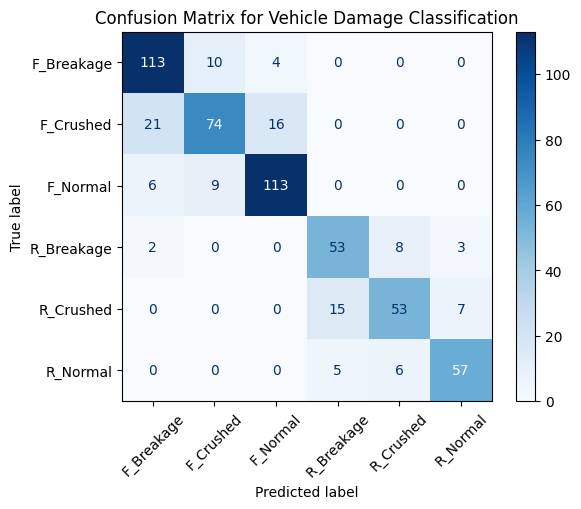

In [185]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(all_labels, all_predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

In [186]:
torch.save(model.state_dict(),'saved_model.pth')